Scott Karr  
IS620 Project2

### Project requirements:

* Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
* Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
* What can you infer about each of the distinct groups?

### References
https://patch.com/new-york/new-york-city/just-45-middle-schools-gave-specialized-high-schools-60-percent-their
https://www.nytimes.com/interactive/2018/06/29/nyregion/nyc-high-schools-middle-schools-shsat-students.html    
http://jonathansoma.com/lede/algorithms-2017/classes/networks/networkx-graphs-from-source-target-dataframe/  
https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python

* Chi-squared was used instead of a t-test to ev

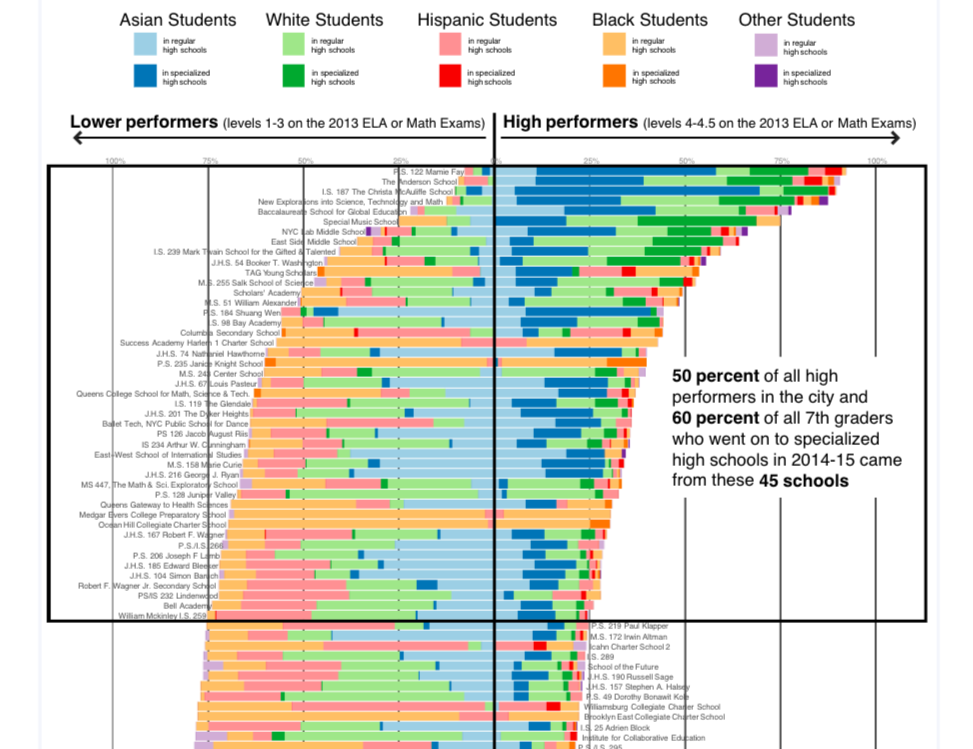
##### Image from patch.com article cited above . . .

### Background
Access to elite high school in New York City is fraught with a dual mission to both provide merit-based opportunity and to reflect the diverse demographics of the city's 1,200,000 students. A seat at one of the Specialized High Schools is soley based upon the SHSAT admissions test and they are largely filled by just a handful of specialty middle schools as based on data released by the city and referenced in the NYTimes and patch.com articles linked above.

According to these articles "... just 45 schools (out of 536 public middle schools) delivered a whopping 60 percent of students to specialized high schools in 2014-15" and "124 middle schools " sent " no students".  "Out of about 600 public middle schools, just 10 account for more than 1,200, or 25 percent of the offers"  The NYtimes article goes on to state that these 10 top performing middle schools are disproportionately Asian and White, in a school system that is two-thirds Hispanic and black. It also cites the following references material . . .

Source: New York City Department of Education |Note: Detailed data for schools with fewer than six offers was not made available. These schools may have anywhere from zero to five offers.  The schools with the highest numbers of offers are mostly in some of New York’s wealthiest neighborhoods, like the Upper West Side in Manhattan and Park Slope in Brooklyn. Twenty-nine students at Junior High School 118 in the Bronx received offers, the highest number for a school in that borough. That’s only 7 percent of the school’s eighth graders, compared with 75 percent of eighth graders at the Christa McAuliffe School in Brooklyn, which sent the most children to the specialized schools last year.

Across the city, only 34 percent of eighth graders even took the entrance exam in 2017, and many schools had only a handful of students take it. At the top 10 schools, 70 percent of students took the test.

Below, see the number of offers for each public middle school in New York City, and the percentage of students at each school who are black and Hispanic.


### Objective
Once again, this exercise is an analysis of the equitablility in apportioning qualified students to the city's specialized schools.  This time, I've identified a large 2-node network dataset with ties between the two distinct catagories.  The network catagories are middle schools within the NYC Department of Education and their proportinate level of economic disadvantage by decile and the schools geolocation by zipcode.  The list is then filtered by zipcodes that send top performing students on to NYC's 8 Speacialized High Schools.  The zipcodes are aggregated by decile indicating the proportion of students sent from schools in that zipcode.

### Load & Merge Datasets

In [15]:
# load libraries
import matplotlib
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite as bi
from operator import itemgetter

#### Load NYC shsat dataset which will be used to implement the "Island" method of filtering all but key nodes out of the dataset.

In [2]:
# load 2017-18 middle school that send students to select specialized high schools based up SHSAT test scores
dfshsat = pd.read_csv("nyc-shsat-data.csv")
dfshsat.columns = dfshsat.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
# filter out schools that send 0 students
dfshsat = dfshsat[dfshsat["offers"] != 's']
dfshsat = dfshsat[dfshsat["offers"] != 's^']
dfshsat = dfshsat[dfshsat["testers"] != 's']
dfshsat['offers'] = dfshsat['offers'].astype(int)
dfshsat['testers'] = dfshsat['testers'].astype(int)
dfshsat['school_name'] = dfshsat['school_name'].str.lower()
dfshsat['dbn'] = dfshsat['dbn'].str.replace(" ","")
dfshsat['accpt_decile'] = (dfshsat['offers'] / dfshsat['testers'] * 10).astype(int) * 10
dfshsat = dfshsat[['dbn', 'school_name','accpt_decile']]
dfshsat.sort_values(by=['accpt_decile'], ascending=False, inplace=True)
# sort and display by acceptance decile or ~percentage of students accepted to specialized high schools
dfshsat.head()

,dbn,school_name,accpt_decile
470,20K187,the christa mcauliffe school\i.s. 187,80
491,03M334,the anderson school,70
480,01M539,"new explorations into science, technology and ...",70
486,02M114,east side middle school,60
498,30Q122,p.s. 122 mamie fay,60


#### Load NYC middle schools deciles by %disadvantaged dataset used to implement the "Island" method.

In [3]:
# load 2017-18 middle school economic disadvantage dataset and clean data
dfdisadv = pd.read_csv("MiddleSchoolELAScoresByPassedGrade7_2019.csv")
dfdisadv.columns = dfdisadv.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
dfdisadv = dfdisadv[['dbn', '%disadvantaged']]
dfdisadv['dbn'] = dfdisadv['dbn'].str.replace(" ","")
dfdisadv['%disadvantaged'] = (dfdisadv['%disadvantaged']* 10).astype(int) * 10
dfdisadv.head()


,dbn,%disadvantaged
0,01M034,90
1,01M140,80
2,01M184,70
3,01M188,90
4,01M332,80


In [4]:
# load 2017-18 middle school locations dataset and clean data
df = pd.read_csv("2017_-_2018_School_Locations.csv")
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df = df[['ats_system_code', 'location_name', 'grades_text','location_1']]
df['zip'] = df['location_1'].str.split('\n').str[1]
df['zip'] = df.zip.str.replace(r"[a-zA-Z,','']",'')
df['zip'] = df['zip'].str.replace(" ","")
df['location_name'] = df['location_name'].str.lower()
df = df[['ats_system_code','location_name','zip']]
df.columns = ['dbn', 'school_name','zip']
df['dbn'] = df['dbn'].str.replace(" ","")
df = df[pd.notnull(df['zip'])]
# sort and display by district-borough-number which keys on district, borough and school number
df.sort_values(by=['dbn'], inplace=True)
df.head()

,dbn,school_name,zip
0,01M015,p.s. 015 roberto clemente,10009
1,01M019,p.s. 019 asher levy,10003
2,01M020,p.s. 020 anna silver,10002
3,01M034,p.s. 034 franklin d. roosevelt,10009
4,01M063,the star academy - p.s.63,10009


In [5]:
# combine datasets for only schools that send students to specialized schools
df_cd = pd.merge(df, dfshsat, how='inner', on = 'school_name')
df_cd.sort_values(by=['accpt_decile'], ascending=False, inplace=True)
df_cd['zip'] = df_cd['zip'].str.replace(" ","")
df_cd['dbn'] = df_cd['dbn_x'].str.replace(" ","")
df_cd = pd.merge(df_cd, dfdisadv, how='inner', on = 'dbn')
df_cd['disadvantaged'] = df_cd['%disadvantaged']
df_cd = df_cd[['dbn', 'school_name', 'zip','accpt_decile','disadvantaged']]
sorted(df_cd, key=itemgetter(1), reverse=True)
df_cd.head()

,dbn,school_name,zip,accpt_decile,disadvantaged
0,20K187,the christa mcauliffe school\i.s. 187,11219,80,60
1,03M334,the anderson school,10024,70,20
2,30Q300,the 30th avenue school (g&t citywide),11102,60,20
3,30Q122,p.s. 122 mamie fay,11105,60,50
4,02M114,east side middle school,10128,60,10


### Draw Initial Graph 
Use the dataframe of combined schools as an edge list for an initial graph display that relates
acceptance rates to zipcodes.  Note, each acceptance decile can have (1 -> many edges) since there are 
multiple schools per zipcode.

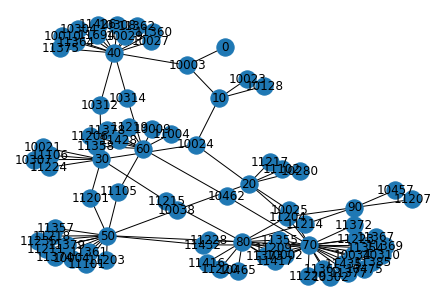

In [8]:
# initial visualization of network
g = nx.from_pandas_edgelist(df_cd,'disadvantaged', 'zip')
nx.draw(g,  with_labels=True)

In [9]:
# Make a list of zips, we'll use it later
zips = list(df_cd.zip.unique())
# Make a list of the decile of students accepted to specialized schools, we'll use it later
lvlofdisadv = list(df_cd.disadvantaged.unique())

### Graph degree scaled by Node Size, differentiated by Node Type

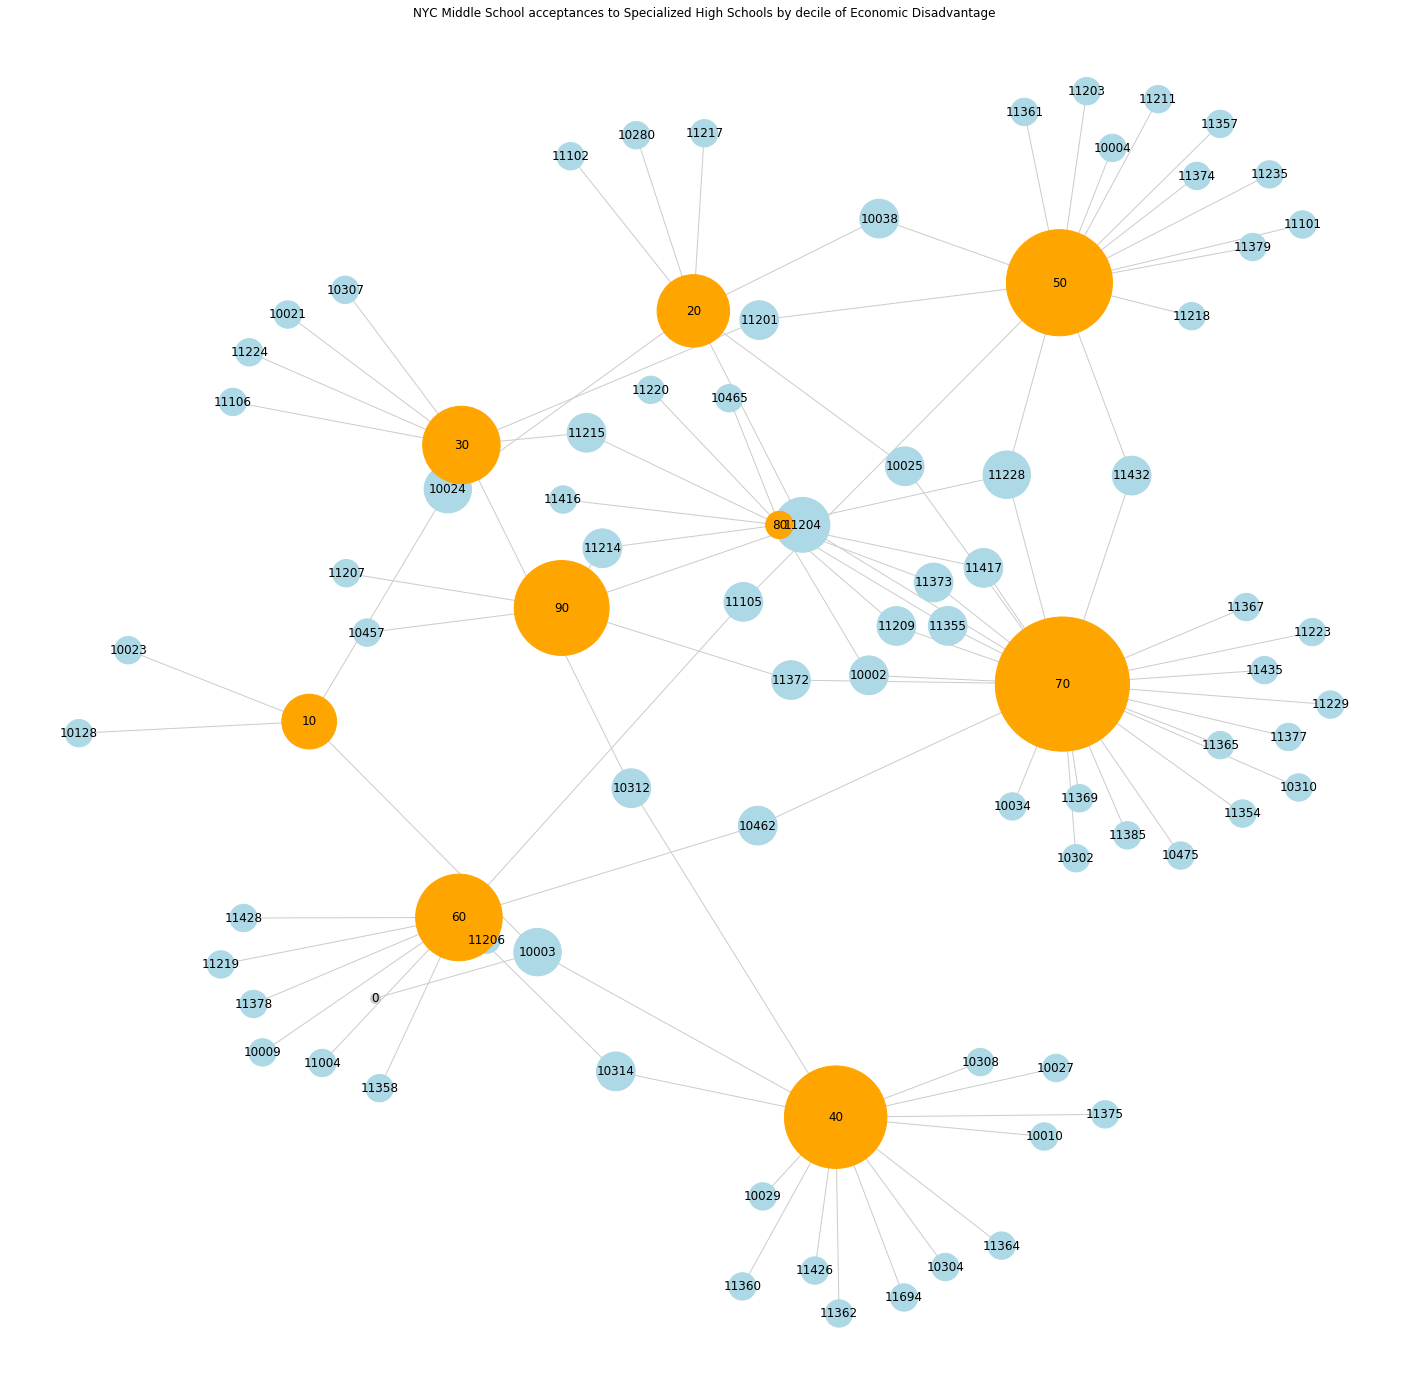

In [10]:
# Articulate centrality by weighting by node size the degree of connectivity.  Also distinguish between 
# acceptance nodes and zipcode nodes using color.
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 25))

# 1. Create the graph
g = nx.from_pandas_edgelist(df_cd, 'disadvantaged','zip')

# 2. Create a layout for our nodes 
layout = nx.spring_layout(g,iterations=25)

 # 3. Draw the parts we want
# Edges thin and grey
# Passed small and grey
# zipcodes sized according to their number of connections
# show zipcodes in blue
# Acceptance deciles that are highly connected are a highlighted color

# Go through every zipcode, ask the graph how many
# connections it has. Multiply that by 750 to get the circle size
zip_size = [g.degree(zip) * 750 for zip in zips]
nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist=zips, 
                       node_size=zip_size, # a LIST of sizes, based on g.degree
                       node_color='lightblue')

# Draw every level of disadvantage decile
nx.draw_networkx_nodes(g, layout, nodelist=lvlofdisadv, node_color='#cccccc', node_size=100,cmap=plt.cm.Blues)

# Draw acceptances with high Centrality and color those with more than 1 connection to zipcodes
lvlofdisadv_size = [g.degree(disadvantage) * 750 for disadvantage in lvlofdisadv]
performance_ind = [disadvantage for disadvantage in lvlofdisadv if g.degree(disadvantage) > 1]
nx.draw_networkx_nodes(g, layout, nodelist=performance_ind,node_size=lvlofdisadv_size, node_color='orange')
nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")

# Label nodes by zipcodes associated with disadvantage level
node_labels1 = dict(zip(zips, zips))
nx.draw_networkx_labels(g, layout, labels=node_labels1)

# Label nodes by level of disadvantage in deciles
node_labels2 = dict(zip(lvlofdisadv, lvlofdisadv))
nx.draw_networkx_labels(g, layout, labels=node_labels2)

# 4. Turn off the axis and label graph
plt.axis('off')
plt.title("NYC Middle School acceptances to Specialized High Schools by decile of Economic Disadvantage")

# 5. Tell matplotlib to show it
plt.show()

### Analysis by graph inspection . . .
Note that centrality is clear before any statistical anaylysis is done.  Lets evaluate zipcode "11204" as an example as having high degree centrality.  This zipcode has 6 schools that send students to Specialized High Schools at various levels of success despite some high degrees of disadvantage. 

This warrants further exploration of what is working for each school and why?  See some profiles from "Inside Schools"

https://insideschools.org/school/21K226
https://insideschools.org/school/20K180

In [27]:
df_cd[df_cd["zip"] == '11204']

,dbn,school_name,zip,accpt_decile,disadvantaged
10,20K686,brooklyn school of inquiry,11204,50,20
19,20K180,the seeall academy,11204,30,80
87,21K226,p.s. 226 alfred de b.mason,11204,10,70
94,20K227,j.h.s. 227 edward b. shallow,11204,10,90
95,20K223,j.h.s. 223 the montauk,11204,10,90
98,21K096,i.s. 096 seth low,11204,0,70


In [21]:
degree_dict = dict(g.degree(g.nodes()))
nx.set_node_attributes(g, degree_dict, 'degree')
g.node['11204']

{'degree': 4}

### Graph Analysis

The initial plot of the bipartite graph filters out schools that send no students from middle school to Specialized High Schools.  This filter already is a pre-implementation of the island method.  Zipcodes are weighted by the degree of schools sending students and Decile of Disadvantaged students is weighted by the degree of schools sending students with that level of disadvantaged.  

What is shown in the graph shows a more complex dynamic then what was presented by the introductory articles.  Of the schools that do send students to the Specialized High Schools, many come from schools located with high levels of economic disadvantage--as much as 80-90%.  Of course there are many zipcodes and schools that send no students at all but of those schools that do, it appears that economic disadvantage does not predetermine the outcome.

The inference here is that schools in zipcodes such as 11204 are doing something right which should be replicated despite its schools having high levels of economic disadvantage.

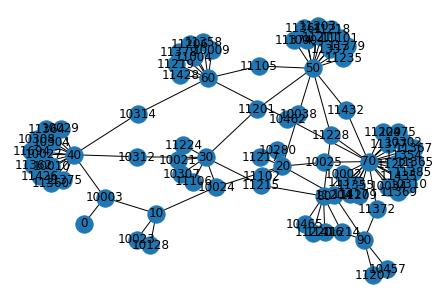

In [13]:
# Get bipartite data
edges = df_cd[['zip','disadvantaged']].values.tolist()
top = list(set(df_cd['zip'].values.tolist()))
bottom = list(set(df_cd['disadvantaged'].values.tolist()))

# Build a bipartite graph:
B = nx.Graph()
B.add_nodes_from(top, bipartite=0) # Add the node attribute “bipartite”
B.add_nodes_from(bottom, bipartite=1)
B.add_edges_from(edges)

# Initial drawing of bipartate graph showing women and clubs
nx.draw(B, with_labels = True)
plt.show()

# Network is well connected. High degree centrality. 

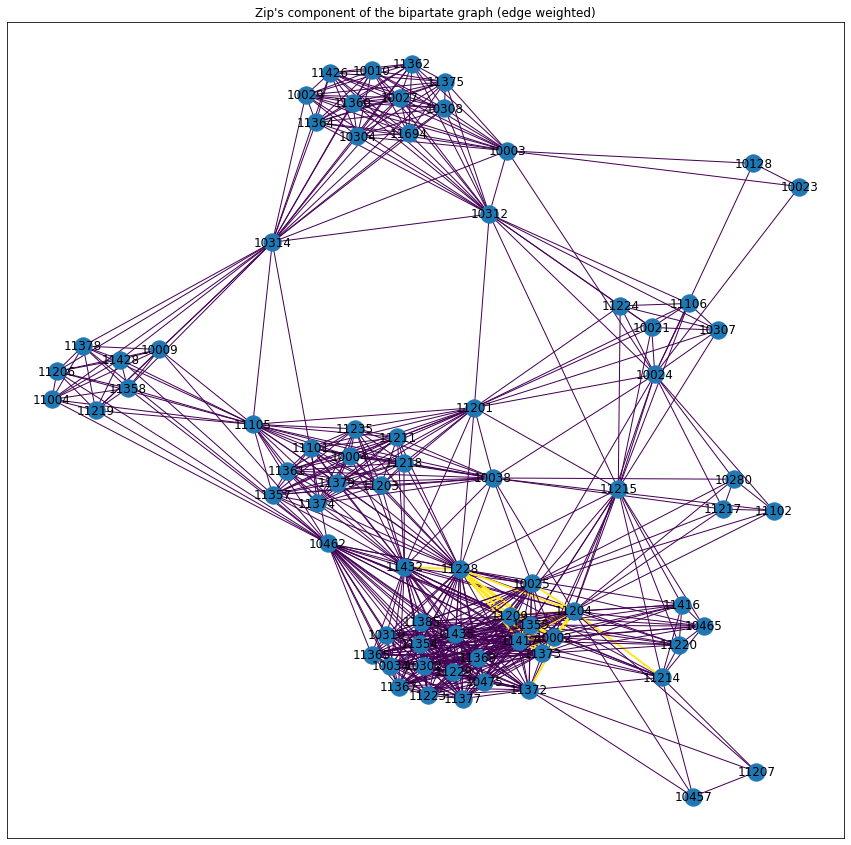

In [18]:
# project weighted graph onto women attendees nodes
Z = bi.weighted_projected_graph(B, top, ratio=False)
weights = [edata['weight'] for f,t,edata in Z.edges(data=True)]
edge_weights = {(u,v,):d['weight'] * .75 for u,v,d in Z.edges(data=True)}

# plot graph
plt.figure(figsize=(15, 15))
plt.title("Zip's component of the bipartate graph (edge weighted)")
nx.draw_networkx(Z, width = weights, edge_color=weights ) 

There are a few strong ties between zips in the center of the graph but we need to calculate Centrality statistics and sort in order to rank their importantance . . .

In [20]:
# Get a top 10 list of zips by betweeness centrality
Zbtw = nx.betweenness_centrality(Z)
s = sorted(Zbtw.items(), key=itemgetter(1), reverse=True)
df = pd.DataFrame(s)
df[:10]

,0,1
0,10462,0.169657
1,10314,0.157291
2,10312,0.103939
3,10024,0.088522
4,11228,0.083353
5,11204,0.079186
6,11215,0.077136
7,11105,0.075440
8,11201,0.069159
9,11432,0.051971


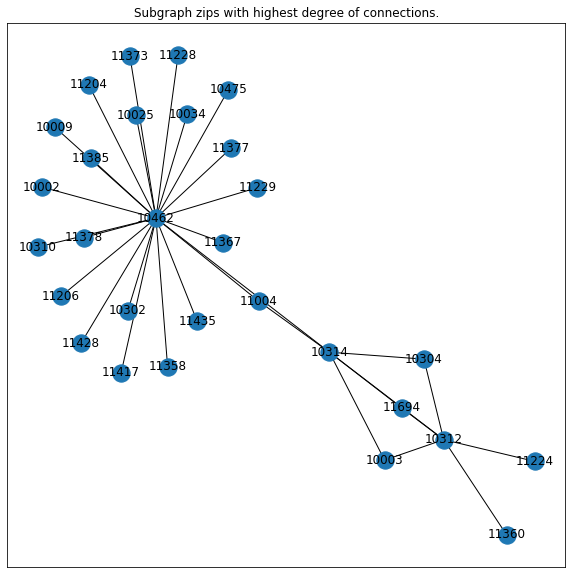

In [26]:
# get the list of top 3 zips with highest degree of centrality and plot their connectedness subgraph
highdeg_zips = list(df.iloc[:3,0])
hd_zips = nx.Graph([(k,v) for k,v in Z.edges() if k in highdeg_zips])
hd_zips.edges()

# plot graph
plt.figure(figsize=(10, 10))
plt.title("Subgraph zips with highest degree of connections.")
nx.draw_networkx(hd_zips) 

Based upon the subgraphs of the zipcodes with the highest degree centrality there are some islands but generally a pattern of highly connected zips.  Zipcode 10462 seems to be very connected between the 60 and 70 deciles of disadvantaged students.

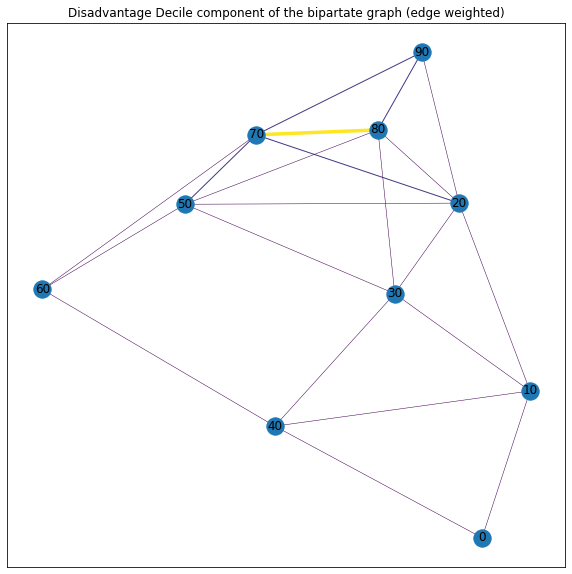

In [25]:
# Now project weighted graph onto disadvantage decile nodes
C = bi.weighted_projected_graph(B, bottom)
C.edges(data=True)
weights=[edata['weight'] * .5 for f,t,edata in C.edges(data=True)]

# plot graph
plt.figure(figsize=(10, 10))
plt.title("Disadvantage Decile component of the bipartate graph (edge weighted)")
nx.draw_networkx(C, width = weights, edge_color=weights) 

For the subgraph of Disadvantage Deciles, 70 and 80 percent levels appear to have the highest degree of centrality i.e. 
the most zipcodes in common that send students at these levels.  This is a somewhat centralized island cluster, evenly dispersed.

### Conclusion of Analysis

With regard to economic disadvantage, the inferences from this analysis are that despite the overall pattern of a select few feeder middle schools sending students to NYC's Specialized High Schools, the pattern within the network of schools that do send students have a wide diversity of economic disadvantage.  This is a hopeful sign suggesting that zipcodes where economic disadvantage is high yet acceptances to Specialized High Schools is significant despite these advantages have lessons that may be able to be replicated in other disadvantaged areas throughout the city.

This is an example of "The Paradox of Composition" i.e. there exists inequities in the selection process across all zipcodes in the city, but within the cohort of zipcodes that send students, this inequity m